# CIFAR10 Dataset
### 1.1 각 pixel의 type을 정수에서 실수로 변경 후 정규화 진행

In [13]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 이미지 데이터 정규화 (픽셀 값 0~255를 0~1로 스케일링)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("train dataset shape:", x_train.shape, y_train.shape)
print("test dataset shape:", x_test.shape, y_test.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


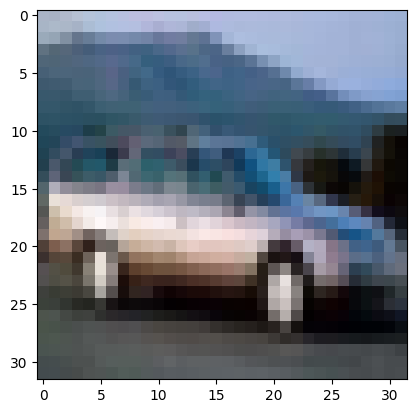

In [14]:
import matplotlib.pyplot as plt

plt.imshow(x_train[4])

### 1.2 Label 데이터 One-Hot Encoding 진행
* 정수형 라벨을 그대도 사용할 경우 모델의 Loss Function인 Categorical_crossentropy 부분에서 에러 발생
* 즉, (50000, 1) -> (50000, 10) 형태로 변경 (CIFAR10 데이터의 Class 수는 10개이다.)

In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("train dataset shape:", x_train.shape, y_train.shape)
print("test dataset shape:", x_test.shape, y_test.shape)

train dataset shape: (50000, 32, 32, 3) (50000, 10)
test dataset shape: (10000, 32, 32, 3) (10000, 10)


# 2. VGGNet


* **Conv 층 13개, FC 층 3개로 구성되어 있습니다.**
* **Input image size는 224x224 크기로 조정되어 첫 번째 Convolutional층으로 전달됩니다.**
* **이루 Conv를 거쳐 특성을 추출하고 입력 데이터는 3x3 크기의 작은 필터를 여러 개 쌓아올린 컨볼루션 층들을 지납니다.**
* **필터 개수는 64 -> 128 -> 256 -> 512로 점진적으로 증가합니다.**
* **중간에 2x2 크기의 Max Pooling이 적용되어 데이터의 공간 해상도를 줄여 가중치 값을 적게 만듭니다.**


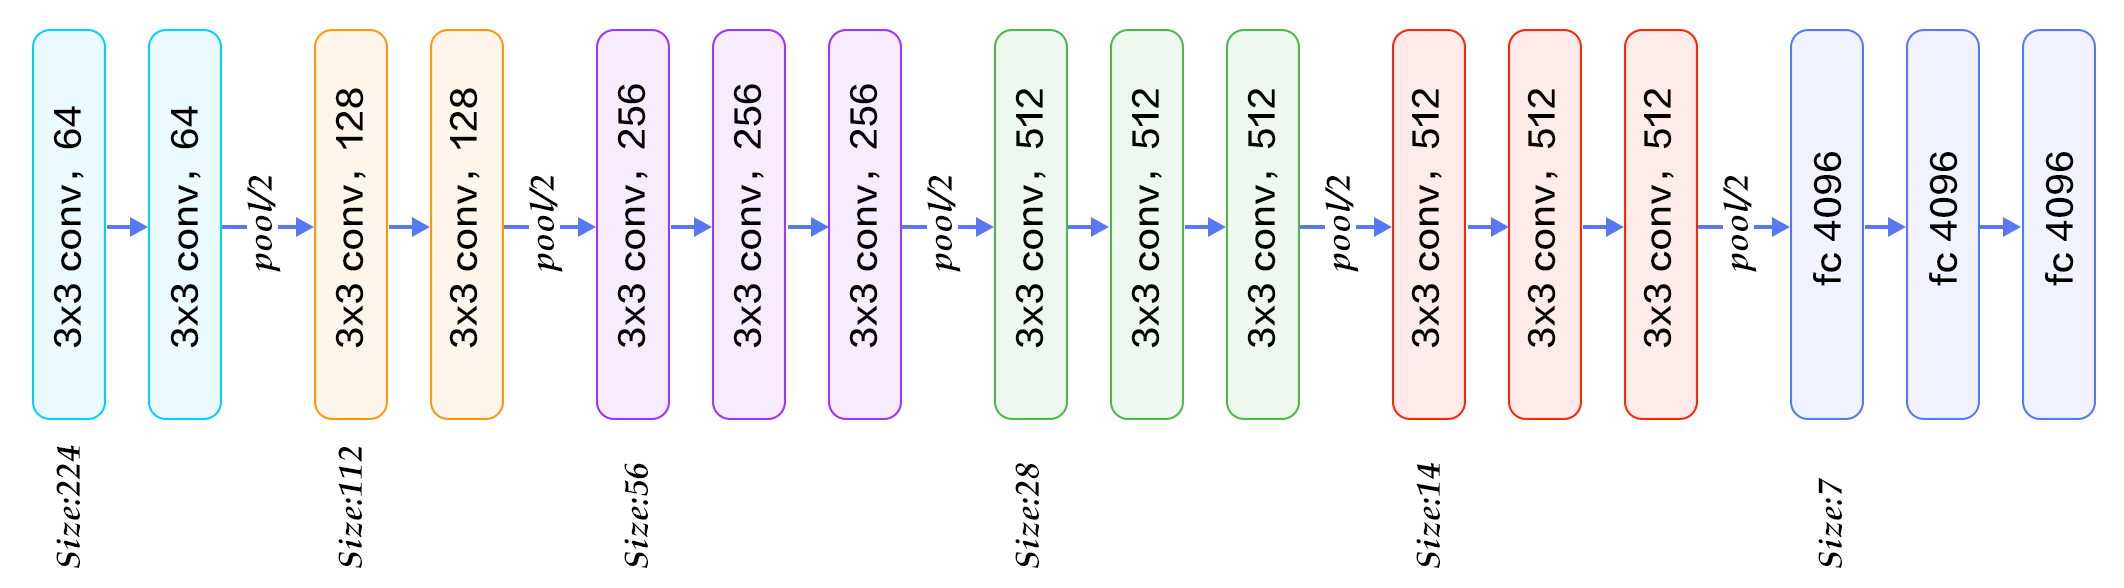

| Layer            | Feature Map | Size             | Kernel Size | Stride | Activation |
|------------------|-------------|------------------|-------------|--------|------------|
| Input            | Image       | 224 x 224 x 3    | -           | -      | -          |
| 2 X Convolution  | 64          | 224 x 224 x 64   | 3x3         | 1      | relu       |
| Max Pooling      | 64          | 112 x 112 x 64   | 2x2         | 2      | relu       |
| 2 X Convolution  | 128         | 112 x 112 x 128  | 3x3         | 1      | relu       |
| Max Pooling      | 128         | 56 x 56 x 128    | 2x2         | 2      | relu       |
| 3 X Convolution  | 256         | 56 x 56 x 256    | 3x3         | 1      | relu       |
| Max Pooling      | 256         | 28 x 28 x 256    | 2x2         | 2      | relu       |
| 3 X Convolution  | 512         | 28 x 28 x 512    | 3x3         | 1      | relu       |
| Max Pooling      | 512         | 14 x 14 x 512    | 2x2         | 2      | relu       |
| 3 X Convolution  | 512         | 14 x 14 x 512    | 3x3         | 1      | relu       |
| Max Pooling      | 512         | 7 x 7 x 512      | 2x2         | 2      | relu       |
| FC               | -           | 25088            | -           | -      | relu       |
| FC               | -           | 4096             | -           | -      | relu       |
| FC               | -           | 4096             | -           | -      | relu       |
| Output           | -           | 1000             | -           | -      | softmax    |


In [17]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn     

### 2-1. VGG-16 구조 그대로 구현


In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

input_shape = (224,24,3)
x = Input(shape = input_shape, name="INPUT")

# CONV 1
conv1_1 = Conv2D(filters=64, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_1_1")(x)
conv1_2 = Conv2D(filters=64, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_1_2")(conv1_1)
pool1 = MaxPooling2D((2,2), padding="same", strides=2, name="POOL1")(conv1_2)

# CONV 2
conv2_1 = Conv2D(filters=128, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_2_1")(pool1)
conv2_2 = Conv2D(filters=128, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_2_2")(conv2_1)
pool2 = MaxPooling2D((2,2), padding="same", strides=2, name="POOL2")(conv2_2)

# CONV 3
conv3_1 = Conv2D(filters=256, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_3_1")(pool2)
conv3_2 = Conv2D(filters=256, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_3_2")(conv3_1)
conv3_3 = Conv2D(filters=256, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_3_3")(conv3_2)
pool3 = MaxPooling2D((2,2), padding="same", strides=2, name="POOL3")(conv3_3)

# CONV 4
conv4_1 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_4_1")(pool3)
conv4_2 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_4_2")(conv4_1)
conv4_3 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_4_3")(conv4_2)
pool4 = MaxPooling2D((2,2), padding="same", strides=2, name="POOL4")(conv4_3)

# CONV 5
conv5_1 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_5_1")(pool4)
conv5_2 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_5_2")(conv5_1)
conv5_3 = Conv2D(filters=512, kernel_size=3, activation="relu", strides=1, padding="same", name="CONV_5_3")(conv5_2)
pool5 = MaxPooling2D((2,2), padding="same", strides=2, name="POOL5")(conv5_3)

# FC
f = Flatten()(pool5)
f = Dense(4096, activation="relu", name="FC_1")(f)
f = Dropout(0.5)(f)
f = Dense(4096, activation="relu", name="FC_2")(f)
f = Dropout(0.5)(f)
out = Dense(1000, activation="softmax", name="OUTPUT")(f)

model = Model(inputs=x, outputs=out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 CONV_1_1 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 CONV_1_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 POOL1 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 CONV_2_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 CONV_2_2 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 POOL2 (MaxPooling2D)        (None, 12, 12, 128)       0     

### 2.2 ImageNet 데이터가 Pre-trained된 VGG16 모델을 Fine-Tuning
* CIFAR10 데이터의 Shape는 32x32x3 이므로 모델의 Input_shape 부분을 (32, 32, 3) 변경
* 그리고 Class가 10개 이므로 마지막 Softmax Layer는 10으로 변경

In [6]:
from tensorflow.keras.applications import VGG16

# loading the model 
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# include_top determines whether to include the fully connected layers at the top of the network.
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

* ImageNet 데이터셋으로 사전 학습된 모델이기에 이미 성능이 좋습니다. 그렇기 때문에 ```trainble = False```를 설정하여 해당 레이어들의 가중치가 학습 중 변경되지 않게 합니다. <span style="color: #2D3748; background-color:#fff5b1;">즉 사전 학습된 VGG-16 모델의 레이어들은 고정되어 있고, 새로운 데이터에 맞춘 추가 레이어인 Flatten 및 Dense 층들만 추가 학습됩니다. </span>

In [7]:
# Freeze the layers of the VGG model
for layer in vgg_model.layers:
    layer.trainable = False

In [9]:
# TensorFlow for deep neural neteworks 
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# adding the FC layers
# Dense layers 
# Create a new model by adding layers on top of VGG
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# to reduce overfitting 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# Train the model with EarlyStopping
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=50, batch_size=64,
                    callbacks=[early_stopping])

Epoch 1/50


2024-10-11 12:50:35.270373: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8600


  7/782 [..............................] - ETA: 13s - loss: 2.6394 - accuracy: 0.1295 

2024-10-11 12:50:35.685449: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


782/782 [==============================] - 16s 18ms/step - loss: 1.9261 - accuracy: 0.3166 - val_loss: 1.5941 - val_accuracy: 0.4632
Epoch 2/50
782/782 [==============================] - 13s 16ms/step - loss: 1.5899 - accuracy: 0.4439 - val_loss: 1.4531 - val_accuracy: 0.5065
Epoch 3/50
782/782 [==============================] - 13s 16ms/step - loss: 1.4763 - accuracy: 0.4870 - val_loss: 1.3842 - val_accuracy: 0.5268
Epoch 4/50
782/782 [==============================] - 12s 16ms/step - loss: 1.4150 - accuracy: 0.5082 - val_loss: 1.3423 - val_accuracy: 0.5395
Epoch 5/50
782/782 [==============================] - 14s 18ms/step - loss: 1.3704 - accuracy: 0.5211 - val_loss: 1.3097 - val_accuracy: 0.5493
Epoch 6/50
782/782 [==============================] - 13s 17ms/step - loss: 1.3391 - accuracy: 0.5365 - val_loss: 1.2861 - val_accuracy: 0.5542
Epoch 7/50
782/782 [==============================] - 12s 16ms/step - loss: 1.3125 - accuracy: 0.5447 - val_loss: 1.2662 - val_accuracy: 0.5586
Epo

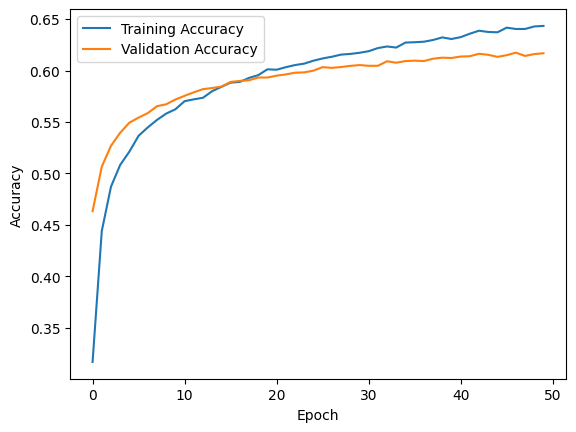

In [21]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Reference
* https://modulabs.co.kr/blog/vggnet_structure/ -> VGG-16 관련 설명 및 추가 네트워크 추천
* https://www.kaggle.com/code/erenicoz/object-detection-cifar10-with-vgg19 -> 코드
* https://www.kaggle.com/code/hossamahmedsalah/vgg-transfer-learning-with-cifar-10 -> 코드